# Import

In [24]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from keras import Model, Sequential, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping
from overcome_tomorrow.utils.data import *
from overcome_tomorrow.ml_logic.preprocess import *
from overcome_tomorrow.ml_logic.model import *
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from sklearn import set_config; set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load DATA

In [2]:
garmin_data, activities = get_data()


⌛ Loading activities data from BigQuery server... ⌛ 
✅ activities data loaded, with shape (3363, 35)

⌛ Loading garmin_data data from BigQuery server... ⌛ 
✅ garmin_data data loaded, with shape (3445, 53)


# filter data per activity type

In [3]:
filters = {
    "sport": ["cycling", "running", "swimming"]
}

In [4]:
sport_filter = ["cycling", "running", "swimming"]

In [5]:
filtered_activities = activities[activities["sport"].isin(sport_filter)]
filtered_activities.tail(10)

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
3349,2024-03-11 18:17:41+00:00,0.0,3.999,NaN,3.1,NaN,91.0,155.0,generic,31.0,2024-03-11 17:34:32+00:00,10276.66,NaN,689.0,596.0,91.0,running,2.0,1415.9,4.507,69.0,NaN,50.0,50.0,None,354.0,97.694046,32.0,350.0,NaN,NaN,84.0,138.0,466.0,nicko64@hotmail.fr_240665171225
3351,2024-03-12 07:23:28+00:00,0.0,9.075,NaN,3.2,NaN,NaN,130.0,virtual_activity,234.0,2024-03-12 05:19:43+00:00,67182.03,NaN,1449.0,1805.0,120.0,cycling,3.0,NaN,13.427,88.0,NaN,66.0,66.0,None,223.0,114.251968,213.0,221.0,9360.0,131.5,76.0,116.0,356.0,nicko64@hotmail.fr_240769117539
3352,2024-03-12 07:34:08+00:00,0.0,5.654,NaN,1.5,NaN,NaN,141.0,indoor_cycling,NaN,2024-03-12 07:23:57+00:00,3401.64,NaN,158.0,173.0,81.0,cycling,1.0,NaN,6.392,66.0,NaN,62.0,61.0,None,266.0,22.180191,NaN,264.0,741.0,14.6,73.0,127.0,320.0,nicko64@hotmail.fr_240770883882
3353,2024-03-12 18:46:59+00:00,0.0,4.215,NaN,3.8,NaN,94.0,164.0,generic,42.0,2024-03-12 17:44:05+00:00,15179.46,NaN,999.0,888.0,94.0,running,3.0,1475.6,4.945,78.0,NaN,44.0,44.0,None,365.0,172.981277,44.0,363.0,NaN,NaN,85.0,147.0,464.0,nicko64@hotmail.fr_240860374328
3355,2024-03-13 07:49:03+00:00,0.0,8.869,NaN,3.5,NaN,NaN,141.0,gravel_cycling,288.0,2024-03-13 05:35:17+00:00,70631.01,NaN,1202.0,1930.0,99.0,cycling,3.0,NaN,11.617,91.0,NaN,63.0,63.0,None,223.0,146.113831,288.0,220.0,9964.0,142.2,75.0,126.0,390.0,nicko64@hotmail.fr_240966169031
3356,2024-03-13 18:54:11+00:00,0.0,4.022,NaN,3.3,NaN,91.0,159.0,generic,52.0,2024-03-13 17:43:45+00:00,16341.00,NaN,1128.0,943.0,91.0,running,2.0,1427.0,4.721,77.0,NaN,53.0,53.0,None,340.0,125.475555,54.0,338.0,NaN,NaN,84.0,141.0,431.0,nicko64@hotmail.fr_241056055877
3357,2024-03-14 07:52:39+00:00,0.0,8.895,NaN,3.7,NaN,NaN,138.0,gravel_cycling,284.0,2024-03-14 05:39:29+00:00,70766.39,NaN,962.0,1953.0,111.0,cycling,3.0,NaN,11.785,93.0,NaN,61.0,61.0,None,226.0,164.412140,285.0,223.0,9939.0,145.2,75.0,129.0,379.0,nicko64@hotmail.fr_241159952127
3359,2024-03-14 18:32:31+00:00,0.0,3.955,NaN,3.3,NaN,90.0,153.0,generic,52.0,2024-03-14 17:21:40+00:00,16012.68,NaN,1124.0,929.0,90.0,running,2.0,1404.1,4.283,94.0,NaN,71.0,71.0,None,339.0,116.148071,56.0,338.0,NaN,NaN,84.0,142.0,413.0,nicko64@hotmail.fr_241246052903
3360,2024-03-15 07:45:23+00:00,0.0,8.657,NaN,3.5,NaN,NaN,142.0,gravel_cycling,298.0,2024-03-15 05:25:09+00:00,72616.84,NaN,1371.0,2019.0,104.0,cycling,3.0,NaN,11.915,95.0,NaN,67.0,67.0,None,221.0,144.809784,296.0,218.0,10737.0,147.4,77.0,127.0,418.0,nicko64@hotmail.fr_241349530713
3362,2024-03-15 11:26:17+00:00,0.0,3.521,NaN,1.5,NaN,88.0,139.0,generic,13.0,2024-03-15 11:14:42+00:00,2337.73,NaN,184.0,140.0,88.0,running,1.0,1265.6,4.749,95.0,NaN,91.0,91.0,None,323.0,22.125320,16.0,319.0,NaN,NaN,84.0,126.0,442.0,nicko64@hotmail.fr_241377639543


<AxesSubplot:ylabel='Frequency'>

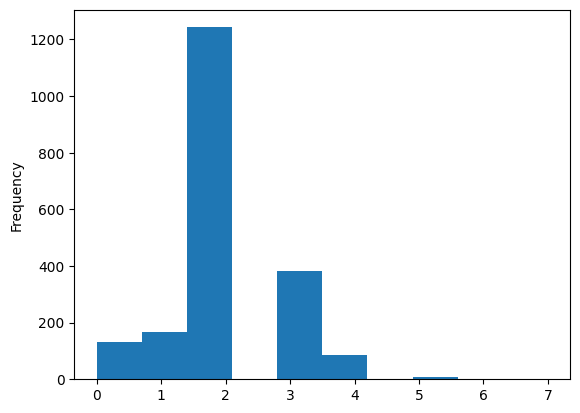

In [6]:
filtered_activities["188"].plot.hist()

In [7]:
filtered_activities[filtered_activities["188"] == 0]

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
283,2020-01-25 12:56:36+00:00,NaN,0.720,0.0,NaN,46.0,NaN,70.0,lap_swimming,NaN,2020-01-25 12:03:07+00:00,2300.00,50.0,NaN,561.0,NaN,swimming,0.0,NaN,2.326,NaN,46.0,NaN,NaN,metric,NaN,0.000000,NaN,NaN,1308.0,NaN,25.0,70.0,NaN,nicko64@hotmail.fr_48105747053
548,2020-05-20 11:01:54+00:00,0.0,6.608,NaN,0.5,NaN,NaN,121.0,mountain,28.0,2020-05-20 10:44:27+00:00,6795.57,NaN,193.0,134.0,NaN,cycling,0.0,NaN,8.286,NaN,NaN,NaN,NaN,None,NaN,7.540970,28.0,NaN,NaN,NaN,NaN,108.0,NaN,nicko64@hotmail.fr_56336749795
578,2020-05-30 19:49:54+00:00,0.0,5.699,NaN,0.7,NaN,NaN,129.0,generic,31.0,2020-05-30 19:21:14+00:00,9760.52,NaN,320.0,200.0,NaN,cycling,0.0,NaN,6.746,NaN,NaN,NaN,NaN,None,NaN,9.734558,36.0,NaN,NaN,NaN,NaN,108.0,NaN,nicko64@hotmail.fr_57237023632
611,2020-06-13 16:03:09+00:00,0.0,6.616,NaN,0.5,NaN,NaN,129.0,generic,114.0,2020-06-13 15:49:44+00:00,5252.37,NaN,130.0,106.0,NaN,cycling,0.0,NaN,12.400,NaN,NaN,NaN,NaN,None,NaN,7.150574,41.0,NaN,NaN,NaN,NaN,111.0,NaN,nicko64@hotmail.fr_58442051290
625,2020-06-19 16:16:23+00:00,0.0,6.602,NaN,0.8,NaN,NaN,124.0,generic,107.0,2020-06-19 15:34:23+00:00,16332.27,NaN,456.0,274.0,NaN,cycling,0.0,NaN,7.959,NaN,NaN,NaN,NaN,None,NaN,10.853607,34.0,NaN,NaN,NaN,NaN,106.0,NaN,nicko64@hotmail.fr_58977911734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2023-08-28 09:14:22+00:00,0.0,0.686,0.0,0.6,24.0,NaN,137.0,lap_swimming,NaN,2023-08-28 08:55:38+00:00,600.00,25.0,NaN,109.0,NaN,swimming,0.0,NaN,1.042,NaN,24.0,NaN,NaN,metric,NaN,9.028412,NaN,NaN,288.0,NaN,20.0,110.0,NaN,nicko64@hotmail.fr_206714877913
2801,2023-08-28 16:42:47+00:00,0.0,8.861,NaN,0.8,NaN,NaN,117.0,indoor_cycling,NaN,2023-08-28 16:32:40+00:00,5322.09,NaN,121.0,135.0,107.0,cycling,0.0,NaN,9.144,100.0,NaN,98.0,98.0,None,205.0,12.101959,NaN,202.0,794.0,11.0,79.0,110.0,229.0,nicko64@hotmail.fr_206768535768
2875,2023-10-01 12:53:22+00:00,0.0,0.235,8.7,0.0,NaN,NaN,109.0,open_water,NaN,2023-10-01 12:48:55+00:00,52.19,NaN,22.0,16.0,29.0,swimming,0.0,NaN,0.620,NaN,NaN,NaN,NaN,None,NaN,0.717346,NaN,NaN,6.0,NaN,1.0,90.0,NaN,nicko64@hotmail.fr_212574354598
3217,2024-02-03 16:27:19+00:00,0.0,6.469,NaN,0.4,NaN,NaN,136.0,road,5.0,2024-02-03 16:20:32+00:00,2516.03,NaN,37.0,64.0,136.0,cycling,0.0,NaN,10.170,63.0,NaN,62.0,62.0,None,163.0,5.913086,22.0,143.0,428.0,3.3,73.0,119.0,325.0,nicko64@hotmail.fr_233781904268


In [8]:
filtered_activities_dict = {sport: activities[activities["sport"].isin([sport])].reset_index(drop=True) for sport in sport_filter}

# Train on subset data

In [ ]:
for sport, sport_activities in filtered_activities_dict.items():
    model_filename = f"{sport}_{MODEL_NAME}"
    #Small hack for swimming to avoid preprocessor to throw an error.
    if sport in ("simming", "walking"):
        sport_activities["205"] = 100
    create_train_and_save_model_for_data(garmin_data=garmin_data, activities=sport_activities, model_filename=model_filename)

# Load sub model/preprocessors

In [22]:
for sport, sport_activities in filtered_activities_dict.items():
    model_filename = f"{sport}_{MODEL_NAME}"
    preproc_garmin_data, preproc_activity, model = load_preprocessors_and_model(model_filename=model_filename)
    a = sport_activities.tail(3)
    t = preproc_activity.transform(sport_activities.tail(3))
    display(a)
    display(t)
    display(preproc_activity.inverse_transform(t))

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,total_training_effect,max_heart_rate,sub_sport,total_descent,start_time,total_distance,178,total_calories,max_cadence,sport,188,enhanced_max_speed,205,206,207,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
973,2024-03-13 07:49:03+00:00,0.0,8.869,3.5,141.0,gravel_cycling,288.0,2024-03-13 05:35:17+00:00,70631.01,1202.0,1930.0,99.0,cycling,3.0,11.617,91.0,63.0,63.0,223.0,146.113831,288.0,220.0,9964.0,142.2,75.0,126.0,390.0,nicko64@hotmail.fr_240966169031
974,2024-03-14 07:52:39+00:00,0.0,8.895,3.7,138.0,gravel_cycling,284.0,2024-03-14 05:39:29+00:00,70766.39,962.0,1953.0,111.0,cycling,3.0,11.785,93.0,61.0,61.0,226.0,164.412140,285.0,223.0,9939.0,145.2,75.0,129.0,379.0,nicko64@hotmail.fr_241159952127
975,2024-03-15 07:45:23+00:00,0.0,8.657,3.5,142.0,gravel_cycling,298.0,2024-03-15 05:25:09+00:00,72616.84,1371.0,2019.0,104.0,cycling,3.0,11.915,95.0,67.0,67.0,221.0,144.809784,296.0,218.0,10737.0,147.4,77.0,127.0,418.0,nicko64@hotmail.fr_241349530713


,knn_imputer__training_load_peak,knn_imputer__total_descent,knn_imputer__enhanced_max_speed,knn_imputer__178,knn_imputer__total_anaerobic_training_effect,knn_imputer__total_calories,knn_imputer__total_training_effect,knn_imputer__total_ascent,knn_imputer__206,knn_imputer__total_distance,knn_imputer__enhanced_avg_speed,knn_imputer__avg_heart_rate,knn_imputer__188,knn_imputer__max_heart_rate,knn_imputer__207,knn_imputer__missingindicator_total_descent,knn_imputer__missingindicator_enhanced_max_speed,knn_imputer__missingindicator_178,knn_imputer__missingindicator_total_anaerobic_training_effect,knn_imputer__missingindicator_total_training_effect,knn_imputer__missingindicator_total_ascent,knn_imputer__missingindicator_206,knn_imputer__missingindicator_avg_heart_rate,knn_imputer__missingindicator_max_heart_rate,knn_imputer__missingindicator_207,cat_encoder__sport_cycling,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos,imputer 100__205
973,1.244778,0.827926,-0.178643,0.883291,0.0,1.510092,0.8,0.833333,-1.073171,0.862769,0.067726,-0.583333,1.0,-0.769231,-0.866667,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.889017,-0.457874,0.994056,0.108867,-9.0
974,1.534666,0.801643,-0.125050,0.480269,0.0,1.541567,1.0,0.813333,-1.268293,0.866584,0.085695,-0.333333,1.0,-1.000000,-1.044444,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.882948,-0.469472,0.995805,0.091502,-7.0
975,1.224119,0.893634,-0.083579,1.167086,0.0,1.631885,0.8,0.886667,-0.682927,0.918732,-0.078784,-0.500000,1.0,-0.692308,-0.511111,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.896873,-0.442289,0.988362,0.152123,-5.0


,training_load_peak,total_descent,enhanced_max_speed,178,total_anaerobic_training_effect,total_calories,total_training_effect,total_ascent,206,total_distance,enhanced_avg_speed,avg_heart_rate,188,max_heart_rate,207,sport,timestamp,start_time,205
0,146.113831,288.0,11.617,1202.0,0.0,1930.0,3.5,288.0,63.0,70631.01,8.869,126.0,3.0,141.0,63.0,cycling,7:49:00,5:35:00,91.0
1,164.412140,284.0,11.785,962.0,0.0,1953.0,3.7,285.0,61.0,70766.39,8.895,129.0,3.0,138.0,61.0,cycling,7:51:59,5:39:00,93.0
2,144.809784,298.0,11.915,1371.0,0.0,2019.0,3.5,296.0,67.0,72616.84,8.657,127.0,3.0,142.0,67.0,cycling,7:45:00,5:25:00,95.0


,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,total_training_effect,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,206,207,normalized_power,training_load_peak,total_ascent,avg_power,avg_cadence,avg_heart_rate,max_power,activity_id
711,2024-03-13 18:54:11+00:00,0.0,4.022,3.3,91.0,159.0,generic,52.0,2024-03-13 17:43:45+00:00,16341.00,1128.0,943.0,91.0,running,2.0,1427.0,4.721,77.0,53.0,53.0,340.0,125.475555,54.0,338.0,84.0,141.0,431.0,nicko64@hotmail.fr_241056055877
712,2024-03-14 18:32:31+00:00,0.0,3.955,3.3,90.0,153.0,generic,52.0,2024-03-14 17:21:40+00:00,16012.68,1124.0,929.0,90.0,running,2.0,1404.1,4.283,94.0,71.0,71.0,339.0,116.148071,56.0,338.0,84.0,142.0,413.0,nicko64@hotmail.fr_241246052903
713,2024-03-15 11:26:17+00:00,0.0,3.521,1.5,88.0,139.0,generic,13.0,2024-03-15 11:14:42+00:00,2337.73,184.0,140.0,88.0,running,1.0,1265.6,4.749,95.0,91.0,91.0,323.0,22.125320,16.0,319.0,84.0,126.0,442.0,nicko64@hotmail.fr_241377639543


,knn_imputer__training_load_peak,knn_imputer__total_descent,knn_imputer__enhanced_max_speed,knn_imputer__178,knn_imputer__total_anaerobic_training_effect,knn_imputer__total_calories,knn_imputer__total_training_effect,knn_imputer__total_ascent,knn_imputer__206,knn_imputer__total_distance,knn_imputer__enhanced_avg_speed,knn_imputer__avg_heart_rate,knn_imputer__188,knn_imputer__max_heart_rate,knn_imputer__207,knn_imputer__missingindicator_178,knn_imputer__missingindicator_206,knn_imputer__missingindicator_avg_heart_rate,knn_imputer__missingindicator_max_heart_rate,knn_imputer__missingindicator_207,cat_encoder__sport_running,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos,imputer 100__205
711,-0.243556,-0.463415,0.136729,0.862109,0.0,0.187583,-0.428571,-0.503311,-1.16,0.135246,-0.386646,-0.888889,0.0,-0.636364,-1.082126,0.0,-1.0,0.0,0.0,-1.0,1.0,-0.972370,0.233445,-0.997250,-0.074108,-23.0
712,-0.364159,-0.463415,-1.037534,0.852839,0.0,0.150594,-0.428571,-0.450331,0.28,0.090917,-0.594720,-0.777778,0.0,-1.181818,0.309179,0.0,-1.0,0.0,0.0,-1.0,1.0,-0.990268,0.139173,-0.985556,-0.169350,-6.0
713,-1.579865,-1.414634,0.211796,-1.325608,0.0,-1.933950,-3.000000,-1.509934,1.88,-1.755422,-1.942547,-2.555556,-1.0,-2.454545,1.855072,0.0,-1.0,0.0,0.0,-1.0,1.0,0.147809,-0.989016,0.199368,-0.979925,-5.0


,training_load_peak,total_descent,enhanced_max_speed,178,total_anaerobic_training_effect,total_calories,total_training_effect,total_ascent,206,total_distance,enhanced_avg_speed,avg_heart_rate,188,max_heart_rate,207,sport,timestamp,start_time,205
0,125.475555,52.0,4.721,1128.0,0.0,943.0,3.3,54.0,53.0,16341.00,4.022,141.0,2.0,159.0,53.0,running,18:53:59,17:43:59,77.0
1,116.148071,52.0,4.283,1124.0,0.0,929.0,3.3,56.0,71.0,16012.68,3.955,142.0,2.0,153.0,71.0,running,18:32:00,17:21:00,94.0
2,22.125320,13.0,4.749,184.0,0.0,140.0,1.5,16.0,91.0,2337.73,3.521,126.0,1.0,139.0,91.0,running,11:26:00,11:14:00,95.0


,timestamp,enhanced_avg_speed,avg_stroke_distance,max_heart_rate,sub_sport,start_time,total_distance,total_calories,sport,188,enhanced_max_speed,205,training_load_peak,total_strokes,avg_cadence,avg_heart_rate,activity_id
329,2024-02-17 10:02:01+00:00,0.578,0.0,137.0,lap_swimming,2024-02-17 08:11:50+00:00,3800.0,840.0,swimming,2.0,2.062,100,52.170517,2726.0,25.0,125.0,nicko64@hotmail.fr_236285541286
330,2024-02-19 07:34:12+00:00,0.544,0.0,142.0,lap_swimming,2024-02-19 06:47:43+00:00,1475.0,338.0,swimming,2.0,0.669,100,38.211884,1121.0,25.0,127.0,nicko64@hotmail.fr_236643866931
331,2024-03-09 09:47:30+00:00,0.578,0.0,143.0,lap_swimming,2024-03-09 09:01:40+00:00,1500.0,354.0,swimming,1.0,0.710,100,34.587540,1074.0,25.0,125.0,nicko64@hotmail.fr_240209471766


,knn_imputer__training_load_peak,knn_imputer__total_distance,knn_imputer__enhanced_avg_speed,knn_imputer__enhanced_max_speed,knn_imputer__188,knn_imputer__avg_heart_rate,knn_imputer__total_calories,knn_imputer__max_heart_rate,cat_encoder__sport_swimming,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos,imputer 100__205
329,-0.040706,1.245902,-0.558333,3.115638,0.0,-0.377358,1.061728,-0.6875,1.0,0.492424,-0.870356,0.841039,-0.540974,0.0
330,-0.390073,-1.803279,-1.125000,-0.222888,0.0,-0.226415,-1.417284,-0.3750,1.0,0.917060,-0.398749,0.979045,-0.203642,0.0
331,-0.480785,-1.770492,-0.558333,-0.124626,-1.0,-0.377358,-1.338272,-0.3125,1.0,0.548293,-0.836286,0.704015,-0.710185,0.0


,training_load_peak,total_distance,enhanced_avg_speed,enhanced_max_speed,188,avg_heart_rate,total_calories,max_heart_rate,sport,timestamp,start_time,205
0,52.170517,3800.0,0.578,2.062,2.0,125.0,840.0,137.0,swimming,10:02:00,8:11:00,100.0
1,38.211884,1475.0,0.544,0.669,2.0,127.0,338.0,142.0,swimming,7:34:00,6:47:00,100.0
2,34.587540,1500.0,0.578,0.710,1.0,125.0,354.0,143.0,swimming,9:47:00,9:01:00,100.0


# Test preprocessor inverter on submodel

In [20]:
swimming = filtered_activities_dict["swimming"]
swimming["205"] = 100
swimming.dropna(axis = 1, how="all", inplace = True)
test_preproc = create_preproc_activity(swimming)
test_preproc.fit(swimming)
a = swimming.tail(3)
t = test_preproc.transform(swimming.tail(3))
display(a)
display(t)
display(test_preproc.inverse_transform(t))

,timestamp,enhanced_avg_speed,avg_stroke_distance,max_heart_rate,sub_sport,start_time,total_distance,total_calories,sport,188,enhanced_max_speed,205,training_load_peak,total_strokes,avg_cadence,avg_heart_rate,activity_id
329,2024-02-17 10:02:01+00:00,0.578,0.0,137.0,lap_swimming,2024-02-17 08:11:50+00:00,3800.0,840.0,swimming,2.0,2.062,100,52.170517,2726.0,25.0,125.0,nicko64@hotmail.fr_236285541286
330,2024-02-19 07:34:12+00:00,0.544,0.0,142.0,lap_swimming,2024-02-19 06:47:43+00:00,1475.0,338.0,swimming,2.0,0.669,100,38.211884,1121.0,25.0,127.0,nicko64@hotmail.fr_236643866931
331,2024-03-09 09:47:30+00:00,0.578,0.0,143.0,lap_swimming,2024-03-09 09:01:40+00:00,1500.0,354.0,swimming,1.0,0.710,100,34.587540,1074.0,25.0,125.0,nicko64@hotmail.fr_240209471766


,knn_imputer__training_load_peak,knn_imputer__total_distance,knn_imputer__enhanced_avg_speed,knn_imputer__enhanced_max_speed,knn_imputer__188,knn_imputer__avg_heart_rate,knn_imputer__total_calories,knn_imputer__max_heart_rate,cat_encoder__sport_swimming,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos,imputer 100__205
329,-0.040706,1.245902,-0.558333,3.115638,0.0,-0.377358,1.061728,-0.6875,1.0,0.492424,-0.870356,0.841039,-0.540974,0.0
330,-0.390073,-1.803279,-1.125000,-0.222888,0.0,-0.226415,-1.417284,-0.3750,1.0,0.917060,-0.398749,0.979045,-0.203642,0.0
331,-0.480785,-1.770492,-0.558333,-0.124626,-1.0,-0.377358,-1.338272,-0.3125,1.0,0.548293,-0.836286,0.704015,-0.710185,0.0


,training_load_peak,total_distance,enhanced_avg_speed,enhanced_max_speed,188,avg_heart_rate,total_calories,max_heart_rate,sport,timestamp,start_time,205
0,52.170517,3800.0,0.578,2.062,2.0,125.0,840.0,137.0,swimming,10:02:00,8:11:00,100.0
1,38.211884,1475.0,0.544,0.669,2.0,127.0,338.0,142.0,swimming,7:34:00,6:47:00,100.0
2,34.587540,1500.0,0.578,0.710,1.0,125.0,354.0,143.0,swimming,9:47:00,9:01:00,100.0


# Test from python code

In [26]:
garmin_data, activities = get_data()
create_train_and_save_sports_sub_model_for_data(garmin_data=garmin_data, activities=activities, model_filename="notebook_model.keras")


⌛ Loading activities data from BigQuery server... ⌛ 
✅ activities data loaded, with shape (3363, 35)

⌛ Loading garmin_data data from BigQuery server... ⌛ 
✅ garmin_data data loaded, with shape (3445, 53)

👷‍♂️ Create and train model cycling_notebook_model.keras 👷‍♀️


⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 916/916 [01:01<00:00, 14.88it/s]


Epoch 1/50
29/29 [==============================] - 5s 34ms/step - loss: 2.1253 - accuracy: 0.2664
Epoch 2/50
29/29 [==============================] - 1s 30ms/step - loss: 1.8242 - accuracy: 0.3941
Epoch 3/50
29/29 [==============================] - 1s 29ms/step - loss: 1.7562 - accuracy: 0.4116
Epoch 4/50
29/29 [==============================] - 1s 28ms/step - loss: 1.7358 - accuracy: 0.4192
Epoch 5/50
29/29 [==============================] - 1s 29ms/step - loss: 1.7296 - accuracy: 0.4105
Epoch 6/50
29/29 [==============================] - 1s 30ms/step - loss: 1.7106 - accuracy: 0.3843
Epoch 7/50
29/29 [==============================] - 1s 32ms/step - loss: 1.6813 - accuracy: 0.3963
Epoch 8/50
29/29 [==============================] - 1s 28ms/step - loss: 1.6602 - accuracy: 0.3865
Epoch 9/50
29/29 [==============================] - 1s 29ms/step - loss: 1.6470 - accuracy: 0.3865
Epoch 10/50
29/29 [==============================] - 1s 27ms/step - loss: 1.6515 - accuracy: 0.4105
Epoch 11/

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 654/654 [00:47<00:00, 13.82it/s]


Epoch 1/50
21/21 [==============================] - 4s 28ms/step - loss: 2.3630 - accuracy: 0.2278
Epoch 2/50
21/21 [==============================] - 1s 29ms/step - loss: 2.0818 - accuracy: 0.3563
Epoch 3/50
21/21 [==============================] - 1s 30ms/step - loss: 1.9725 - accuracy: 0.3624
Epoch 4/50
21/21 [==============================] - 1s 28ms/step - loss: 1.8881 - accuracy: 0.3945
Epoch 5/50
21/21 [==============================] - 1s 27ms/step - loss: 1.8810 - accuracy: 0.3960
Epoch 6/50
21/21 [==============================] - 1s 29ms/step - loss: 1.8728 - accuracy: 0.3914
Epoch 7/50
21/21 [==============================] - 1s 28ms/step - loss: 1.8109 - accuracy: 0.3792
Epoch 8/50
21/21 [==============================] - 1s 28ms/step - loss: 1.8012 - accuracy: 0.3823
Epoch 9/50
21/21 [==============================] - 1s 27ms/step - loss: 1.8225 - accuracy: 0.3914
Epoch 10/50
21/21 [==============================] - 1s 28ms/step - loss: 1.8412 - accuracy: 0.3930
Epoch 11/

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:17<00:00, 15.29it/s]


Epoch 1/50
9/9 [==============================] - 5s 36ms/step - loss: 1630.4890 - accuracy: 0.0184
Epoch 2/50
9/9 [==============================] - 0s 31ms/step - loss: 1611.4214 - accuracy: 0.0221
Epoch 3/50
9/9 [==============================] - 0s 32ms/step - loss: 1597.7725 - accuracy: 0.1471
Epoch 4/50
9/9 [==============================] - 0s 29ms/step - loss: 1586.0668 - accuracy: 0.2426
Epoch 5/50
9/9 [==============================] - 0s 32ms/step - loss: 1578.0367 - accuracy: 0.2463
Epoch 6/50
9/9 [==============================] - 0s 26ms/step - loss: 1572.0029 - accuracy: 0.2059
Epoch 7/50
9/9 [==============================] - 0s 28ms/step - loss: 1567.3038 - accuracy: 0.1838
Epoch 8/50
9/9 [==============================] - 0s 29ms/step - loss: 1563.5201 - accuracy: 0.2059
Epoch 9/50
9/9 [==============================] - 0s 30ms/step - loss: 1560.4814 - accuracy: 0.1949
Epoch 10/50
9/9 [==============================] - 0s 29ms/step - loss: 1556.9863 - accuracy: 0.2022

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:42<00:00, 17.20it/s]


Epoch 1/50
23/23 [==============================] - 4s 30ms/step - loss: 1.7893 - accuracy: 0.2748
Epoch 2/50
23/23 [==============================] - 1s 26ms/step - loss: 1.7353 - accuracy: 0.4503
Epoch 3/50
23/23 [==============================] - 1s 27ms/step - loss: 1.7265 - accuracy: 0.4735
Epoch 4/50
23/23 [==============================] - 1s 26ms/step - loss: 1.7135 - accuracy: 0.4054
Epoch 5/50
23/23 [==============================] - 1s 28ms/step - loss: 1.6960 - accuracy: 0.3823
Epoch 6/50
23/23 [==============================] - 1s 29ms/step - loss: 1.6962 - accuracy: 0.4041
Epoch 7/50
23/23 [==============================] - 1s 29ms/step - loss: 1.6843 - accuracy: 0.4150
Epoch 8/50
23/23 [==============================] - 1s 26ms/step - loss: 1.6682 - accuracy: 0.4000
Epoch 9/50
23/23 [==============================] - 1s 26ms/step - loss: 1.6549 - accuracy: 0.3769
Epoch 10/50
23/23 [==============================] - 1s 29ms/step - loss: 1.6501 - accuracy: 0.4054
Epoch 11/